# Group Lasso using Tensorflow

## 读入数据

In [23]:
import tensorflow as tf

In [24]:
from tensorflow.examples.tutorials.mnist import input_data

In [25]:
mnist=input_data.read_data_sets("~/mnist_data",one_hot=True,validation_size=10000)

Extracting ~/mnist_data/train-images-idx3-ubyte.gz
Extracting ~/mnist_data/train-labels-idx1-ubyte.gz
Extracting ~/mnist_data/t10k-images-idx3-ubyte.gz
Extracting ~/mnist_data/t10k-labels-idx1-ubyte.gz


In [26]:
mnist.train.images.shape,mnist.train.labels.shape

((50000, 784), (50000, 10))

In [27]:
mnist.validation.images.shape,mnist.validation.labels.shape

((10000, 784), (10000, 10))

In [28]:
mnist.test.images.shape,mnist.test.labels.shape

((10000, 784), (10000, 10))

In [56]:
def L21_norm(W):
    if len(W.shape)==1:
        res=tf.norm(W)
    else:
        res=tf.reduce_sum(tf.norm(W,axis=-1))
    return res

def L1_reg(v):
    L1_loss=tf.reduce_sum([tf.reduce_sum(tf.abs(W)) for W in v])
    return L1_loss

def L2_reg(v):
    L2_loss=tf.reduce_sum([tf.reduce_sum(tf.square(W)) for W in v])
    return L2_loss

def group_regularization(v):
    coeff=lambda W:tf.sqrt(tf.cast(W.get_shape().as_list()[-1],tf.float32))
    L1_loss=L1_reg(v)
    res=tf.reduce_sum([tf.multiply(coeff(W),L21_norm(W)) for W in v])+L1_loss
    return res
    
def f_lamb_a(w,a,lamb):
    condition=w<a*lamb
    if len(condition.shape)==0:
        res=tf.where(condition,
                 tf.cast(lamb*tf.abs(w)-tf.square(w)/(2*a),tf.float32),
                 tf.cast(a*tf.square(lamb)/2,tf.float32))
    else:
        fill_units=condition.get_shape()
        res=tf.where(condition,
                 tf.cast(lamb*tf.abs(w)-tf.square(w)/(2*a),tf.float32),
                 tf.tile([tf.cast(a*tf.square(lamb)/2,tf.float32)],fill_units))
    return res
    
def inside_MCP(W,lamb,a):
    K=W.get_shape().as_list()[-1]
    f=lambda w:f_lamb_a(w,a=a,lamb=lamb)
    if len(W.shape)==1:
        u_jk=f(W)
        u_j=tf.reduce_sum(u_jk)
    else:
        u_jk=tf.map_fn(f,W)
        u_j=tf.reduce_sum(u_jk,axis=-1)
    return u_j,K

def convinience(W,lamb,a):
    IMCP=inside_MCP(W,lamb,a)
    res=tf.reduce_sum(f_lamb_a(IMCP[0],IMCP[1]*a*lamb/2,lamb))
    return res

def con2(W,lamb,a):
    coeff=tf.sqrt(tf.cast(W.get_shape().as_list()[-1],tf.float32))
    if len(W.shape)==1:
        norm=tf.norm(W)
    else:
        #norm=tf.reduce_sum(tf.norm(W,axis=-1))
        norm=tf.norm(W,axis=-1)
    inside=coeff*norm
    #return inside
    MCP=f_lamb_a(inside,a,lamb)
    res=tf.reduce_sum(MCP)
    return res
    
def CMCP(v,lamb,a):
    inside_part=[convinience(W,lamb,a) for W in v]
    res=tf.reduce_sum(inside_part)
    return res


def manyReg(v,lam_SGL,lam_GMCP,a):
    res=[]
    for W in v:
        print(W.name)
        if "hidden1/Weight:0" in W.name:
            firLayer=W
        else:
            res.append(W)
    ret=lam_SGL*group_regularization(res)+group_MCP(firLayer,lam_GMCP,a)
    return ret

    
def create_layer(in_var,in_size,out_size):
    W=tf.Variable(tf.truncated_normal([in_size,out_size],stddev=0.1),name="Weight")
    b=tf.Variable(tf.truncated_normal([out_size],stddev=0.1),name="bias")
    res=tf.nn.relu(tf.matmul(in_var,W)+b)
    return res
    
def main(mnist,epochs,batch_size,s,reg_method="SGL"):
    with tf.Graph().as_default():
        X=tf.placeholder(tf.float32,[None,28*28],name="input")
        d=tf.placeholder(tf.float32,[None,10],name="target")
        batch=tf.Variable(0,trainable=False)

        with tf.name_scope("hidden1"):
            h1=create_layer(X, 784, 400)
        with tf.name_scope("hidden2"):
            h2=create_layer(h1,400,300)
        with tf.name_scope("hidden3"):
            h3=create_layer(h2,300,100)
        with tf.name_scope("output"):
            y=create_layer(h3,100,10)

        count_neurons=lambda W:tf.reduce_sum(tf.cast(tf.greater(tf.reduce_mean(tf.abs(W),axis=-1),10**(-3)),tf.float32))

        v=tf.trainable_variables()
        res_neurons=[count_neurons(W) for W in v]
        res_total_neurons=tf.reduce_sum(res_neurons)

        with tf.name_scope("cross_entropy_loss"):
            loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,labels=d))
        if reg_method=="SGL":
            with tf.name_scope("SGL"):
                lamb=10**-4
                reg_loss=lamb*group_regularization(v)
        elif reg_method=="CMCP":    
            with tf.name_scope("Composite_MCP"):
                lamb=2.6*10**-2
                a=10
                reg_loss=CMCP(v,lamb,a)
        correct_prediction=tf.equal(tf.argmax(d,1),tf.argmax(y,1))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        with tf.Session() as sess:
            with tf.name_scope("train"):
                train_step=tf.train.AdamOptimizer(learning_rate=0.001).minimize(tf.add(loss,reg_loss))
            sess.run(tf.global_variables_initializer())
            train_acc_lis=[]
            val_acc_lis=[]
            res_n_lis=[]
            for i in range(epochs):
                batch=mnist.train.next_batch(batch_size)
                _,record_total_n=sess.run([train_step,res_total_neurons],feed_dict={X:batch[0],d:batch[1]})
                res_n_lis.append(record_total_n)
                record_train_acc=sess.run(accuracy,feed_dict={X:mnist.train.images,d:mnist.train.labels})
                train_acc_lis.append(record_train_acc)
                record_val_acc=sess.run(accuracy,feed_dict={X:mnist.validation.images,d:mnist.validation.labels})
                val_acc_lis.append(record_val_acc)
                if i==epochs-1:
                    print("Final accuracy on train set: ",record_train_acc)
                    print("Final accuracy on validation set: ",record_val_acc)
                    
            if reg_method=="SGL":
                s['train_accuracy']['SGL']=train_acc_lis
                s['validation_accuracy']['SGL']=val_acc_lis
                s["neurons"]['SGL']=res_n_lis
                test_acc=sess.run(accuracy,feed_dict={X:mnist.test.images,d:mnist.test.labels})
                s["test_accuracy"]["SGL"]=test_acc
            elif reg_method=="CMCP":
                s['train_accuracy']['CMCP']=train_acc_lis
                s['validation_accuracy']['CMCP']=val_acc_lis
                s["neurons"]['CMCP']=res_n_lis
                test_acc=sess.run(accuracy,feed_dict={X:mnist.test.images,d:mnist.test.labels})
                s["test_accuracy"]["CMCP"]=test_acc
            print("Final accuracy on test set: ",test_acc)
            neurons_per_layer=sess.run([res_neurons[i] for i in range(0,7,2)])
            print("Final neurons in each layer: ",neurons_per_layer)        
    return s

In [30]:
s={"train_accuracy":{"SGL":[],"CMCP":[]},"validation_accuracy":{"SGL":[],"CMCP":[]},
   "test_accuracy":{"SGL":None,"CMCP":None},"neurons":{"SGL":[],"CMCP":[]}}

In [51]:
res=main(mnist,epochs=2000,batch_size=400,s=s,reg_method="SGL")

Final accuracy on train set:  0.96698
Final accuracy on validation set:  0.9618
Final accuracy on test set:  0.9624
Final neurons in each layer:  [282.0, 53.0, 70.0, 94.0]


In [57]:
res["train_accuracy"]["CMCP"]=[]
res["validation_accuracy"]["CMCP"]=[]
res["test_accuracy"]["CMCP"]=None
res["neurons"]["CMCP"]=[]
res2=main(mnist,epochs=2000,batch_size=400,s=res,reg_method="CMCP")

Final accuracy on train set:  0.9716
Final accuracy on validation set:  0.9632
Final accuracy on test set:  0.9653
Final neurons in each layer:  [328.0, 164.0, 172.0, 81.0]


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


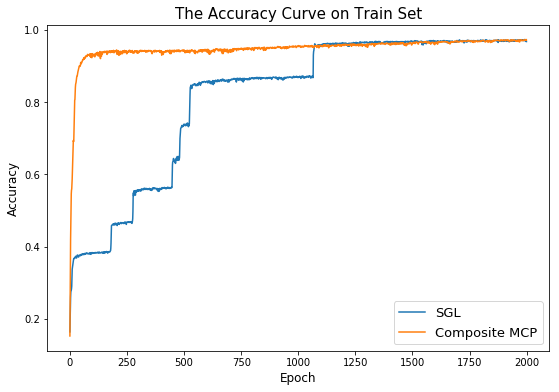

In [58]:
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res2['train_accuracy']['SGL'],label="SGL")
ax.plot(res2["train_accuracy"]["CMCP"],label="Composite MCP")
title=ax.set_title("The Accuracy Curve on Train Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epoch")
ylab=plt.ylabel("Accuracy")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.legend(prop={"size":13})
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


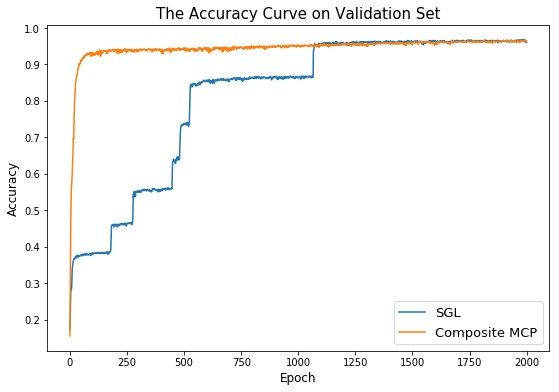

In [59]:
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res['validation_accuracy']['SGL'],label="SGL")
ax.plot(res["validation_accuracy"]["CMCP"],label="Composite MCP")
title=ax.set_title("The Accuracy Curve on Validation Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epoch")
ylab=plt.ylabel("Accuracy")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.legend(prop={"size":13})
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


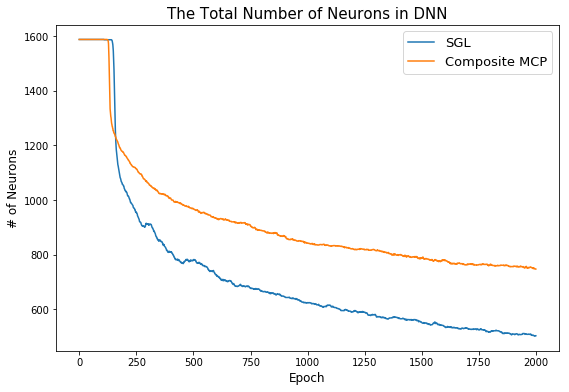

In [60]:
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res['neurons']['SGL'],label="SGL")
ax.plot(res["neurons"]["CMCP"],label="Composite MCP")
title=ax.set_title("The Total Number of Neurons in DNN")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epoch")
ylab=plt.ylabel("# of Neurons")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.legend(prop={"size":13})
plt.show()